Get a plot of water density in the MD model, showing the region selected for collecting further data.

Based on: `p2021-0317a_wdens_bigplot.ipynb`


## Setup

In [1]:
import os
import os.path as osp

In [2]:
import operator
import itertools

In [3]:
from datetime import datetime

In [4]:
import numpy as np

In [5]:
import pandas as pd

In [6]:
import matplotlib.pyplot as plt

In [7]:
%matplotlib inline

In [8]:
import matplotlib as mpl

In [9]:
#Uncomment for print
mpl.rcParams['figure.dpi']= 300

In [10]:
#Uncomment for presentation
mpl.rcParams['xtick.labelsize']="xx-large"
mpl.rcParams['ytick.labelsize']="xx-large"

In [11]:
##from matplotlib.gridspec import GridSpec #Not used at present but potentially useful

In [12]:
from matplotlib.colors import BoundaryNorm

In [13]:
import simproc

In [14]:
import simproc.requesthandler.yaml_manager as yaml_manager
import simproc.requesthandler.pickle_manager as pickle_manager
import simproc.requesthandler.locators as locators

## Constants

In [15]:
taglist=['12A','16A','20A','27pct','50pct','na_27pct']

In [16]:
dlocal_comp_list=["xx","yy","zz","avg"]

In [17]:
dlocal_fname_tmpl="D{comp}_{tag}_nd.csv"

In [18]:
pmf_fname_tmpl="pmf_{tag}_nd.csv"

In [19]:
wdens_fname_tmpl="density_Xplane_{mtag}.pkl"

In [20]:
bbox_fname_tmpl="bbox_{tag}.csv"

In [21]:
plot_fname_tmpl="wdens_plot_{tag}.png"

In [22]:
SELTOL=1e-6

In [23]:
#For print
# font_settings={
#   "cbar_wdens": 16,
#   "cbar_dratio": 32,
#   "cbar_pmf": 16,
#   "axlabels": 12,
#   "axtitle": 14,
# }
#Intermediate
# font_settings={
#   "cbar_wdens": 20,
#   "cbar_dratio": 40,
#   "cbar_pmf": 20,
#   "axlabels": 16,
#   "axtitle": 18,
# }
#For presentation
font_settings={
  "cbar_wdens": 24,
  "cbar_dratio": 40,
  "cbar_pmf": 24,
  "axlabels": 24,
  "axtitle": 24,
}

## Data folder

In [24]:
datadir=osp.abspath("../silicate")
assert osp.isdir(datadir)

In [25]:
o=locators.SetDataFolder(datafolder=datadir)

## Locators

In [26]:
#locators.folder_structure.keys()

In [27]:
locators.folder_structure.update(Unprocessed=['inputs','unprocessed'])

In [28]:
locators.folder_structure.update(Processed=['inputs','processed'])

In [29]:
locators.folder_structure.update(Manual=['inputs','manual'])

In [30]:
Unprocessed=lambda fname: self.renderstr(locators.Unprocessed(fname))

In [31]:
Processed=lambda fname: self.renderstr(locators.Processed(fname))

In [32]:
Manual=lambda fname: self.renderstr(locators.Manual(fname))

## Dummy request for loading data

In [33]:
self=simproc.requesthandler.request.Request(name="ypress.plotting")

## Data file names and paths

Manual data

In [34]:
manualdata_fpath=Manual('other_input_values.yaml')
assert osp.isfile(manualdata_fpath)

$D_{\text{local}}$

In [35]:
dlocal_fpaths={}
for tag in taglist:
  dlocal_fpaths[tag]={comp:Processed(dlocal_fname_tmpl.format(tag=tag,comp=comp)) \
                        for comp in dlocal_comp_list}

In [36]:
dloc_existence_list=[]
for fdict in dlocal_fpaths.values():
  dloc_existence_list+=[osp.isfile(fpath) for fpath in fdict.values()]
assert all(dloc_existence_list)

PMF

In [37]:
pmf_fpaths={tag:Processed(pmf_fname_tmpl.format(tag=tag)) for tag in taglist}

In [38]:
pmf_existence_list=[osp.isfile(fpath) for fpath in pmf_fpaths.values()]
assert all(pmf_existence_list)

Water density

Paths require manual data; see below.

Bounding Box data

In [39]:
bbox_fpaths={tag:Processed(bbox_fname_tmpl.format(tag=tag)) for tag in taglist}

Plot output folder

In [40]:
postproc_top=osp.join(datadir,"postproc","notebooks")

In [41]:
assert osp.isdir(postproc_top)

## Read the input data

Manual

In [42]:
other_input_values=yaml_manager.readfile(manualdata_fpath)

In [43]:
meshes_by_tag=other_input_values["meshes_by_tag"]

$D_\text{local}$

In [44]:
dlocal={}
for tag,pathdict in dlocal_fpaths.items():
  dlocal[tag]= {comp:pd.read_csv(pathdict[comp]) for comp in dlocal_comp_list}

PMF

In [45]:
pmf={tag:pd.read_csv(fpath) for tag,fpath in pmf_fpaths.items()}

Water density

In [46]:
wdens_fpaths={tag:Unprocessed(wdens_fname_tmpl.format(mtag=meshes_by_tag[tag])) for tag in taglist}

In [47]:
wdens_existence_list=[osp.isfile(fpath) for fpath in wdens_fpaths.values()]
assert all(wdens_existence_list)

In [48]:
wdens={tag:pickle_manager.readfile(fpath) for tag,fpath in wdens_fpaths.items()}

Bounding box data

In [49]:
bboxes={tag:pd.read_csv(fpath,index_col=0) for tag,fpath in bbox_fpaths.items()}

## Output plot paths

In [50]:
datestr=datetime.now().strftime("%Y_%m%d")
datestr

'2021_0918'

In [51]:
outdir=osp.join(postproc_top,datestr)

In [52]:
if not osp.isdir(outdir):
  os.makedirs(outdir)
assert osp.isdir(outdir)

## Constants and Functions for plotting

In [53]:
df_xcol="y"
df_ycol="z"

In [54]:
axis_labels=["$y$ [nm]","$z$ [nm]"]

In [55]:
add_labels=axis_labels[:1]+[None]

In [56]:
plot_limits={
  "12A":      ((5.70,6.40), (4.30,6.50)),
  "16A":      ((4.85,5.55), (4.45,6.65)),
  "20A":      ((5.35,6.05), (4.60,6.80)),
  "20A_alt":      ((5.35,6.05), (4.60,6.80)),
  "27pct":    ((4.55,5.25), (4.50,6.70)),
  "50pct":    ((4.35,5.05), (4.50,6.70)),
  "na_27pct": ((4.55,5.25), (4.50,6.70))  
}

In [57]:
wd_level_list=[0.0,0.25,0.75,1.25,1.75,2.25,2.75,3.25,3.75,4.25,4.75,5.25,5.75]
wd_ticks_list=[0.0,0.25,0.75,     1.75,     2.75,     3.75,     4.75,     5.75]

In [58]:
wd_cmap = plt.get_cmap("magma")
wd_norm = BoundaryNorm(wd_level_list, ncolors=wd_cmap.N, extend="max")

In [59]:
def makebounds(bounds_df,xcol="y",ycol="z",idx='limits'):
  xname=xcol.upper()
  yname=ycol.upper()
  xkeys=[xname+v for v in ['min','min','max','max','min']]
  ykeys=[yname+v for v in ['min','max','max','min','min']]
  xvals=[bounds_df.loc[idx,col] for col in xkeys]
  yvals=[bounds_df.loc[idx,col] for col in ykeys]
  return (xvals,yvals)

In [60]:
def plot_bbox(ax,bbox,fmt="g-"):
  bx_x,bx_y=bbox
  ax.plot(bx_x,bx_y,fmt)
  return

In [61]:
bbox_series={tag:makebounds(bbox_df) for tag,bbox_df in bboxes.items()}

In [62]:
def unpack_wdens(wdens_dict):
  return wdens_dict["grid"], wdens_dict["edges"]

In [63]:
def plot_celldata(fig,ax,grid,edges,cmap,norm,cbar_label="",cbar_fontsize=16,ticks=None):
  cntr=ax.pcolormesh(edges[0],edges[1],grid.T,cmap=cmap,norm=norm)
  cbar=fig.colorbar(cntr, ax=ax, ticks=ticks, spacing="proportional")
  cbar.set_label(cbar_label,fontsize=cbar_fontsize)
  o=ax.axis('equal')
  return cntr

In [64]:
def add_standard_features(fig,ax,limits=None,axis_labels=None,axtitle="",lblsize=12,titlesize=14,yticks=True):
  #Axis title
  if len(axtitle)>0:
    ax.set_title(axtitle,fontsize=titlesize)
  #Y-axis tick marks
  if not yticks:
    ax.set_yticklabels([])
  #Axis labels
  if axis_labels is not None:
    xlabel,ylabel=axis_labels
    if xlabel is not None:
      ax.set_xlabel(xlabel,fontsize=lblsize)
    if ylabel is not None:
      ax.set_ylabel(ylabel,fontsize=lblsize)
  #Axis limits
  if limits is not None:
    xlim,ylim=limits
    if xlim is not None:
      ax.set_xlim(xlim)
    if ylim is not None:
      ax.set_ylim(ylim)
    #Troubleshooting axis limits
    #ax.autoscale() #Made the water density go all the way out to its whole data set
    #ax.autoscale_view() #Did nothing, as the documentation indicated it would
    #ax.margins(x=0,y=0,tight=False) #If this did anything, I don't know what it was
    #ax.margins(x=0,y=0,tight=True) #Also had no noticeable effect
    #fig.canvas.draw() #This makes 'got' correct, at least
    #print("requested:",xlim,ylim)
    #print("got:",ax.get_xlim(),ax.get_ylim())  
    #print("margins:",ax.margins())
  return

In [65]:
def do_figure(tag,dcomp="avg"):
  #This function makes use of global variables
  pn=plot_fname_tmpl.format(tag=tag)
  fig,axlist=plt.subplots(1,3,figsize=(16,8))
  limits=plot_limits[tag]
  bbox=bbox_series[tag]
  lblsize=font_settings["axlabels"]
  titlesize=font_settings["axtitle"]
  #Water density
  ax=axlist[0]
  grid,edges=unpack_wdens(wdens[tag])
  axtitle="Water Density"
  cbar_label="Water Density [normalized to SPC bulk value]"
  cbfs=font_settings["cbar_wdens"]
  plot_celldata(fig,ax,grid,edges,cmap=wd_cmap,norm=wd_norm,
                cbar_label=cbar_label,cbar_fontsize=cbfs,ticks=wd_ticks_list)
  plot_bbox(ax,bbox)
  add_standard_features(fig,ax,limits=limits,axis_labels=axis_labels,axtitle=axtitle,
                        lblsize=lblsize,titlesize=titlesize,yticks=True)
  #new_limits=(ax.get_xlim(),ax.get_ylim()) #See what the water density plot needs the limits to be
  #D local
  ax=axlist[1]
  df=dlocal[tag][dcomp]
  axtitle="$D_{{{dcomp}}}$".format(dcomp=dcomp)
  zcol="D{dcomp}".format(dcomp=dcomp)
  cbar_label="$\\frac{D_{\\mathrm{local}}}{D_{\\mathrm{bulk}}}$"
  cbfs=font_settings["cbar_dratio"]
  plot_pointdata(fig,ax,df,df_xcol,df_ycol,zcol,
                 levels=dlocal_levels,vmin=dlocal_valmin,vmax=dlocal_valmax,
                 cmap="plasma",extend="max",
                 cbar_label=cbar_label,cbar_fontsize=cbfs)
  plot_bbox(ax,bbox)
  add_standard_features(fig,ax,limits=limits,axis_labels=add_labels,axtitle=axtitle,
                        lblsize=lblsize,titlesize=titlesize,yticks=True)
  #PMF
  ax=axlist[2]
  df=pmf[tag]
  axtitle="PMF"
  cbar_label="Potential of Mean Force [$k_BT$ at 298 K]"
  cbfs=font_settings["cbar_pmf"]
  plot_pointdata(fig,ax,df,df_xcol,df_ycol,"PMF",
                 levels=pmf_levels,vmin=pmf_valmin,vmax=pmf_valmax,
                 cmap="viridis",extend="max", #cmap="RdBu_r",extend="both",
                 cbar_label=cbar_label,cbar_fontsize=cbfs)
  plot_bbox(ax,bbox)
  add_standard_features(fig,ax,limits=limits,axis_labels=add_labels,axtitle=axtitle,
                        lblsize=lblsize,titlesize=titlesize,yticks=True)
  #Figure additions
  ##o=fig.suptitle(tag)
  fig.tight_layout()
  #Axis limits stuff
  fig.canvas.draw()
  newlim_list=[ax.get_xlim()+ax.get_ylim() for ax in axlist]
  newlim_df=pd.DataFrame(newlim_list,columns=["xmin","xmax","ymin","ymax"])
  new_xlim=(newlim_df["xmin"].min(),newlim_df["xmax"].max())
  new_ylim=(newlim_df["ymin"].min(),newlim_df["ymax"].max())
  for ax in axlist:
    ax.set_xlim(new_xlim)
    ax.set_ylim(new_ylim)
    ax.margins(x=0,y=0,tight=True)
  #fig.canvas.draw() #Not necessary, the above fixed it
  #newlim_list=[ax.get_xlim()+ax.get_ylim() for ax in axlist] #To make sure they really are the same now
  #Save figure
  plot_path=osp.join(outdir,pn)
  fig.savefig(str(plot_path),dpi=150)
  return

## Plots

In [66]:
tag="16A"

In [67]:
pn=plot_fname_tmpl.format(tag=tag)
pn

'wdens_plot_16A.png'

In [68]:
bbox=bbox_series[tag]

In [69]:
lblsize=font_settings["axlabels"]
titlesize=font_settings["axtitle"]

In [70]:
limits=((0,11),(0,11))

In [71]:
grid,edges=unpack_wdens(wdens[tag])

In [72]:
edges[0].shape

(230,)

In [73]:
edges[0][10:15]

array([0.2750004, 0.3250004, 0.3750004, 0.4250004, 0.4750004])

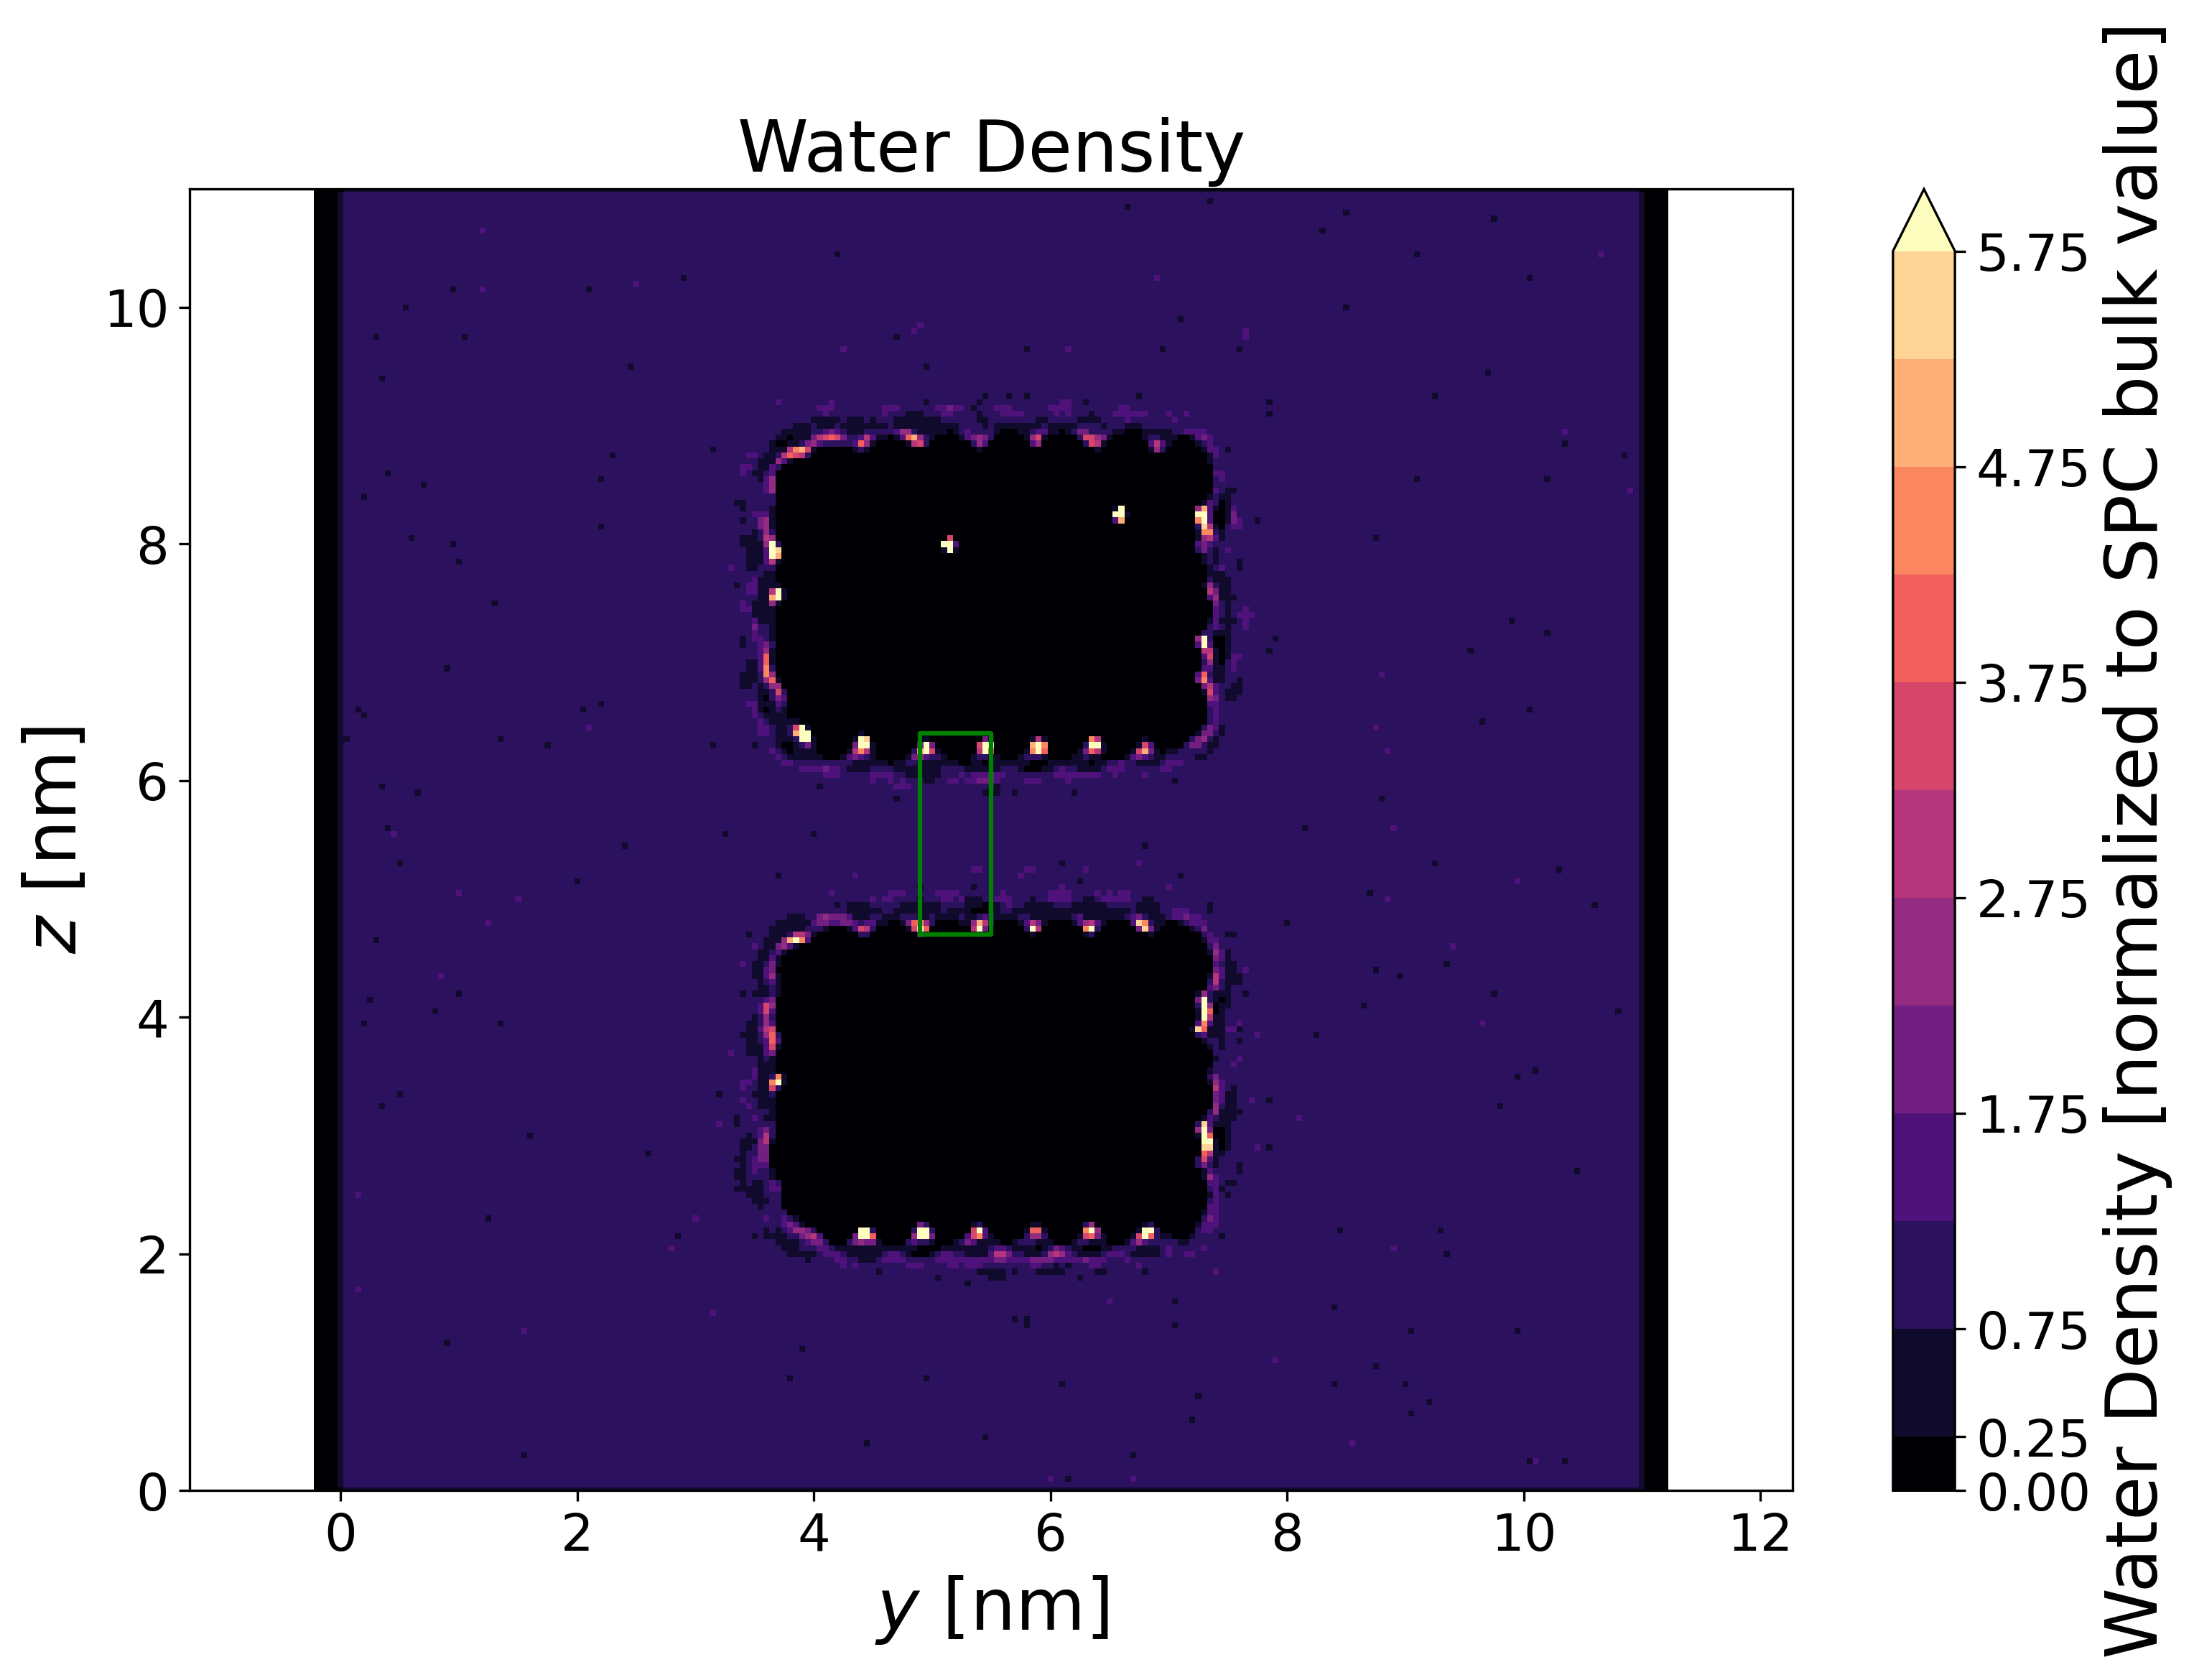

In [74]:
fig,ax = plt.subplots(figsize=(12,8))
axtitle="Water Density"
cbar_label="Water Density [normalized to SPC bulk value]"
cbfs=font_settings["cbar_wdens"]
plot_celldata(fig,ax,grid,edges,cmap=wd_cmap,norm=wd_norm,cbar_label=cbar_label,cbar_fontsize=cbfs,
              ticks=wd_ticks_list)
plot_bbox(ax,bbox)
add_standard_features(fig,ax,limits=limits,axis_labels=axis_labels,axtitle=axtitle,
                      lblsize=lblsize,titlesize=titlesize,yticks=True)
#Save figure
plot_path=osp.join(outdir,pn)
fig.savefig(str(plot_path),dpi=150)